CNNことはじめ

今回はPytorchのコードを追って行きます

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import json
import numpy as np
from PIL import Image

from collections import OrderedDict
import pprint

VGG16を使ってみます。
下記のような記法でデータセットをダウンロードして使うことができます。
推定するときは.eval()のモードを使用します。

In [0]:
vgg16 = models.vgg16(pretrained=True)

モデル構造が表示されます↓　VGG16は Conv2d => ReLU => MaxPool2d の繰り返し

In [113]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

入力画像の準備をして行きます。入力画像に対して以下の変換を施しています。

①256 x 256にリサイズ
②画像の中心部分の 224 x 224 のみ取り出す
③テンソルに変換

In [0]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

以下はgoogle colab用の準備

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id = '1WTN9_GAknq5Bet_hCtUzVFvA0-5DGlxx'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile("dog.png")

In [119]:
!ls

adc.json    grad-cam.py			 sample.csv
cam_gd.jpg  imagenet_class_index.json	 sample_data
cam.jpg     imagenet_class_index.json.1  Shiba_Inu.jpg
dog.png     imagenet_class_index.json.2
gd.jpg	    imgenet_class_index.json


ここまでgoogleの準備

In [120]:
img = Image.open('Shiba_Inu.jpg')
img_tensor = preprocess(img)
print(img_tensor.shape)

torch.Size([3, 224, 224])


In [121]:
torch.Size([3, 224, 224])

torch.Size([3, 224, 224])

<class 'PIL.Image.Image'>


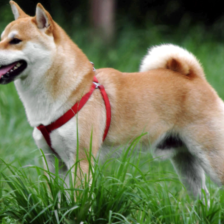

In [122]:
preprocess2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])
trans_img = preprocess2(img)
print(type(trans_img))  # <class 'PIL.Image.Image'>
trans_img

中心部の 224 x 224 が切り取られています。




In [123]:
img_tensor.unsqueeze_(0)
print(img_tensor.size())  # torch.Size([1, 3, 224, 224])

torch.Size([1, 3, 224, 224])


In [124]:
out = vgg16(Variable(img_tensor))
print(out.size())  # torch.Size([1, 1000])

torch.Size([1, 1000])


In [125]:
np.argmax(out.data.numpy())  

263

というわけで、結果が出力されます。

結果を確認してみましょう。ここからVGG１６の答えです

In [126]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2019-02-03 06:55:15--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.0.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.0.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.3’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.07s   

2019-02-03 06:55:15 (531 KB/s) - ‘imagenet_class_index.json.3’ saved [35363/35363]



In [0]:
id = '1WTN9_GAknq5Bet_hCtUzVFvA0-5DGlxx'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('gd.jpg')

In [128]:
!ls

adc.json    grad-cam.py			 imgenet_class_index.json
cam_gd.jpg  imagenet_class_index.json	 sample.csv
cam.jpg     imagenet_class_index.json.1  sample_data
dog.png     imagenet_class_index.json.2  Shiba_Inu.jpg
gd.jpg	    imagenet_class_index.json.3


In [129]:
with open('imagenet_class_index.json.1') as f:
  df = json.load(f)
  
pprint.pprint(df, width=40)

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '10': ['n01530575', 'brambling'],
 '100': ['n01860187', 'black_swan'],
 '101': ['n01871265', 'tusker'],
 '102': ['n01872401', 'echidna'],
 '103': ['n01873310', 'platypus'],
 '104': ['n01877812', 'wallaby'],
 '105': ['n01882714', 'koala'],
 '106': ['n01883070', 'wombat'],
 '107': ['n01910747', 'jellyfish'],
 '108': ['n01914609', 'sea_anemone'],
 '109': ['n01917289', 'brain_coral'],
 '11': ['n01531178', 'goldfinch'],
 '110': ['n01924916', 'flatworm'],
 '111': ['n01930112', 'nematode'],
 '112': ['n01943899', 'conch'],
 '113': ['n01944390', 'snail'],
 '114': ['n01945685', 'slug'],
 '115': ['n01950731', 'sea_slug'],
 '116': ['n01955084', 'chiton'],
 '117': ['n01968897',
         'chambered_nautilus'],
 '118': ['n01978287', 'Dungeness_crab'],
 '119': ['n01978455', 'rock_crab'],
 '12': ['n01532829', 'house_finch'],
 '120': ['n01980166', 'fiddler_crab'],
 '121': ['n01981276', 'king_crab'],
 '122': ['n01983481',
         'American_

In [130]:
print (df['263'])

['n02113023', 'Pembroke']


grad-camはpytorchで実装してくれている人がいました。
https://github.com/jacobgil/pytorch-grad-cam
今回の勉強会用に同梱されているgrad-cam.pyの使い方は上記のサイトをご確認ください。

In [131]:
%%bash
python grad-cam.py --image-path dog.png

  File "grad-cam.py", line 1
SyntaxError: Non-UTF-8 code starting with '\xff' in file grad-cam.py on line 1, but no encoding declared; see http://python.org/dev/peps/pep-0263/ for details
